In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torchvision
from torchvision import datasets, transforms 
import torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import math
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


from models import Encoder, Decoder
from flows import MAF


In [2]:
bkg_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/MinBias_with_ID_small.pt").float()[:, 0:100, :]
sig_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/HH4B_with_ID_small.pt").float()[:, 0:100, :]

/tmp/maglowac/ipykernel_916415/463176679.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bkg_data = torch.load("/eos/user/m/maglowac/Phase2_AD/data_utils/MinBias_with_ID

In [3]:
unique_values, indices = torch.unique(bkg_data[:, :, 3], sorted=True, return_inverse=True)
bkg_data[:, :, 3] = indices.float()

In [4]:
unique_values, indices = torch.unique(sig_data[:, :, 3], sorted=True, return_inverse=True)
sig_data[:, :, 3] = indices.float()

In [5]:
def log_data(data):

    logged_data = data.clone()  # Create a clone to keep the original data unchanged
    first_column = logged_data[:, :, 0]  # Extract the first column

    # Apply np.log where the values are non-zero
    mask = first_column != 0  # Mask for non-zero values
    first_column[mask] = torch.log(first_column[mask])  # Apply log only to non-zero entries

    # Save the modified first column back
    data[:, :, 0] = first_column

    return data

In [6]:
bkg_data = log_data(bkg_data)
sig_data = log_data(sig_data)

In [7]:
class Dataset(Dataset):
    def __init__(self, data, num_pid_classes):
        self.data = data[:, :, 0:3]
        self.pid = data[:, :, 3].long()  # Ensure PID is integer
        self.num_pid_classes = num_pid_classes
        # Create the mask where the first column is non-zero
        self.mask = (data[:, :, 0] != 0).float()  # Shape: [samples, seq_length]

    def __len__(self):
        return self.data.size(0)  # Number of samples

    def __getitem__(self, idx):
        # One-hot encode the PID
        one_hot_pid = F.one_hot(abs(self.pid[idx]), num_classes=self.num_pid_classes).float()
        return {
            "kin": self.data[idx],       # Kinematic features
            "pid": one_hot_pid,          # One-hot encoded PID
            "mask": self.mask[idx]       # Mask for valid entries
        }

# Create the dataset
dataset_bkg = Dataset(bkg_data, 9)
dataset_sig = Dataset(sig_data, 9)

# Create the Data

batch_size = 64 # Define batch size
bkg_loader = DataLoader(dataset_bkg, batch_size=batch_size, shuffle=False)
sig_loader = DataLoader(dataset_sig, batch_size=batch_size, shuffle=False)

In [8]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m).cuda()
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m).cuda()
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

class DeepsetSetVAE(nn.Module):
    def __init__(self, hparams):
        super(DeepsetSetVAE, self).__init__()
        self.hparams = hparams
        self.encoder = Encoder(d_kin=hparams['d_kin'], d_pid=hparams['d_pid'], use_pid=hparams['use_pid'], d_latent=hparams['d_latent']) 
        self.decoder = Decoder(d_pid=hparams['d_pid'], use_pid=hparams['use_pid'], d_latent=hparams['d_latent'])  
        self.angular_scale = hparams['angular_scale']
    
        # MAF parameters
        self.latent_dim = hparams['d_latent']
        self.maf_hidden_size = hparams.get('maf_hidden_size', 64)
        self.num_maf_layers = hparams.get('num_maf_layers', 5)
        self.normalizing_flow = MAF(self.latent_dim, self.maf_hidden_size)
        flow_init = MAF(dim=self.latent_dim)
        flows_init = [flow_init for _ in range(self.num_maf_layers)]
        prior = torch.distributions.MultivariateNormal(torch.zeros(self.latent_dim).cuda(), torch.eye(self.latent_dim).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0

    def forward(self, x, pid, mask):
        # Run Encoder and get NF params
        mu, log_var = self.encoder(x, pid, mask)
    
        z = self.reparameterize(mu, log_var)
 
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF

        z_k, _, sum_ladj = self.flows(z)

     
        kl_div = (kl_div / x.size(0)) #- sum_ladj.mean()  # mean over batch
        
        #print(kl_div)
        #kl_div = torch.clamp(kl_div, min=0, max=10.0)

        # Run Decoder
        x_prime = self.decoder(z_k, pid, mask)
        return x_prime, kl_div, mu, log_var, z_k




In [11]:
hparams = {
    "model": DeepsetSetVAE,
    "d_kin": 3,
    "d_pid": 9,
    "use_pid": True,
    "d_model": 64,
    "d_latent": 16,  # Increased latent dimensionality
    "d_ff": 128,
    "d_output": 3,
    "n_encoder_layers": 4,
    "n_decoder_layers": 4,
    "maf_hidden_size": 8,
    "num_maf_layers": 5,
    "dropout": 0.,
    "beta": 0.08,  # Start with a small nonzero beta
    "angular_scale": 0.1,
    "lr": 0.0005,  # Reduced learning rate
    "batch_size": 256,
    "warmup": 100,
    "patience": 10,
    "factor": 1.0,
    "soft_kl_steps": 10000,  # Faster KL annealing
    "latent_reg_weight": 0.1
}


In [12]:
device = torch.device('cuda')
model = DeepsetSetVAE(hparams)
model.load_state_dict(torch.load('VAE_NF.pth'))
model.to(device)

/tmp/maglowac/ipykernel_916415/3137776350.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('VAE_NF.pth'))


RuntimeError: Error(s) in loading state_dict for DeepsetSetVAE:
	Missing key(s) in state_dict: "normalizing_flow.initial_param", "normalizing_flow.layers.0.network.0.weight", "normalizing_flow.layers.0.network.0.bias", "normalizing_flow.layers.0.network.2.weight", "normalizing_flow.layers.0.network.2.bias", "normalizing_flow.layers.0.network.4.weight", "normalizing_flow.layers.0.network.4.bias", "normalizing_flow.layers.1.network.0.weight", "normalizing_flow.layers.1.network.0.bias", "normalizing_flow.layers.1.network.2.weight", "normalizing_flow.layers.1.network.2.bias", "normalizing_flow.layers.1.network.4.weight", "normalizing_flow.layers.1.network.4.bias", "normalizing_flow.layers.2.network.0.weight", "normalizing_flow.layers.2.network.0.bias", "normalizing_flow.layers.2.network.2.weight", "normalizing_flow.layers.2.network.2.bias", "normalizing_flow.layers.2.network.4.weight", "normalizing_flow.layers.2.network.4.bias", "normalizing_flow.layers.3.network.0.weight", "normalizing_flow.layers.3.network.0.bias", "normalizing_flow.layers.3.network.2.weight", "normalizing_flow.layers.3.network.2.bias", "normalizing_flow.layers.3.network.4.weight", "normalizing_flow.layers.3.network.4.bias", "normalizing_flow.layers.4.network.0.weight", "normalizing_flow.layers.4.network.0.bias", "normalizing_flow.layers.4.network.2.weight", "normalizing_flow.layers.4.network.2.bias", "normalizing_flow.layers.4.network.4.weight", "normalizing_flow.layers.4.network.4.bias", "normalizing_flow.layers.5.network.0.weight", "normalizing_flow.layers.5.network.0.bias", "normalizing_flow.layers.5.network.2.weight", "normalizing_flow.layers.5.network.2.bias", "normalizing_flow.layers.5.network.4.weight", "normalizing_flow.layers.5.network.4.bias", "normalizing_flow.layers.6.network.0.weight", "normalizing_flow.layers.6.network.0.bias", "normalizing_flow.layers.6.network.2.weight", "normalizing_flow.layers.6.network.2.bias", "normalizing_flow.layers.6.network.4.weight", "normalizing_flow.layers.6.network.4.bias", "normalizing_flow.layers.7.network.0.weight", "normalizing_flow.layers.7.network.0.bias", "normalizing_flow.layers.7.network.2.weight", "normalizing_flow.layers.7.network.2.bias", "normalizing_flow.layers.7.network.4.weight", "normalizing_flow.layers.7.network.4.bias", "normalizing_flow.layers.8.network.0.weight", "normalizing_flow.layers.8.network.0.bias", "normalizing_flow.layers.8.network.2.weight", "normalizing_flow.layers.8.network.2.bias", "normalizing_flow.layers.8.network.4.weight", "normalizing_flow.layers.8.network.4.bias", "normalizing_flow.layers.9.network.0.weight", "normalizing_flow.layers.9.network.0.bias", "normalizing_flow.layers.9.network.2.weight", "normalizing_flow.layers.9.network.2.bias", "normalizing_flow.layers.9.network.4.weight", "normalizing_flow.layers.9.network.4.bias", "normalizing_flow.layers.10.network.0.weight", "normalizing_flow.layers.10.network.0.bias", "normalizing_flow.layers.10.network.2.weight", "normalizing_flow.layers.10.network.2.bias", "normalizing_flow.layers.10.network.4.weight", "normalizing_flow.layers.10.network.4.bias", "normalizing_flow.layers.11.network.0.weight", "normalizing_flow.layers.11.network.0.bias", "normalizing_flow.layers.11.network.2.weight", "normalizing_flow.layers.11.network.2.bias", "normalizing_flow.layers.11.network.4.weight", "normalizing_flow.layers.11.network.4.bias", "normalizing_flow.layers.12.network.0.weight", "normalizing_flow.layers.12.network.0.bias", "normalizing_flow.layers.12.network.2.weight", "normalizing_flow.layers.12.network.2.bias", "normalizing_flow.layers.12.network.4.weight", "normalizing_flow.layers.12.network.4.bias", "normalizing_flow.layers.13.network.0.weight", "normalizing_flow.layers.13.network.0.bias", "normalizing_flow.layers.13.network.2.weight", "normalizing_flow.layers.13.network.2.bias", "normalizing_flow.layers.13.network.4.weight", "normalizing_flow.layers.13.network.4.bias", "normalizing_flow.layers.14.network.0.weight", "normalizing_flow.layers.14.network.0.bias", "normalizing_flow.layers.14.network.2.weight", "normalizing_flow.layers.14.network.2.bias", "normalizing_flow.layers.14.network.4.weight", "normalizing_flow.layers.14.network.4.bias", "flows.flows.0.initial_param", "flows.flows.0.layers.0.network.0.weight", "flows.flows.0.layers.0.network.0.bias", "flows.flows.0.layers.0.network.2.weight", "flows.flows.0.layers.0.network.2.bias", "flows.flows.0.layers.0.network.4.weight", "flows.flows.0.layers.0.network.4.bias", "flows.flows.0.layers.1.network.0.weight", "flows.flows.0.layers.1.network.0.bias", "flows.flows.0.layers.1.network.2.weight", "flows.flows.0.layers.1.network.2.bias", "flows.flows.0.layers.1.network.4.weight", "flows.flows.0.layers.1.network.4.bias", "flows.flows.0.layers.2.network.0.weight", "flows.flows.0.layers.2.network.0.bias", "flows.flows.0.layers.2.network.2.weight", "flows.flows.0.layers.2.network.2.bias", "flows.flows.0.layers.2.network.4.weight", "flows.flows.0.layers.2.network.4.bias", "flows.flows.0.layers.3.network.0.weight", "flows.flows.0.layers.3.network.0.bias", "flows.flows.0.layers.3.network.2.weight", "flows.flows.0.layers.3.network.2.bias", "flows.flows.0.layers.3.network.4.weight", "flows.flows.0.layers.3.network.4.bias", "flows.flows.0.layers.4.network.0.weight", "flows.flows.0.layers.4.network.0.bias", "flows.flows.0.layers.4.network.2.weight", "flows.flows.0.layers.4.network.2.bias", "flows.flows.0.layers.4.network.4.weight", "flows.flows.0.layers.4.network.4.bias", "flows.flows.0.layers.5.network.0.weight", "flows.flows.0.layers.5.network.0.bias", "flows.flows.0.layers.5.network.2.weight", "flows.flows.0.layers.5.network.2.bias", "flows.flows.0.layers.5.network.4.weight", "flows.flows.0.layers.5.network.4.bias", "flows.flows.0.layers.6.network.0.weight", "flows.flows.0.layers.6.network.0.bias", "flows.flows.0.layers.6.network.2.weight", "flows.flows.0.layers.6.network.2.bias", "flows.flows.0.layers.6.network.4.weight", "flows.flows.0.layers.6.network.4.bias", "flows.flows.0.layers.7.network.0.weight", "flows.flows.0.layers.7.network.0.bias", "flows.flows.0.layers.7.network.2.weight", "flows.flows.0.layers.7.network.2.bias", "flows.flows.0.layers.7.network.4.weight", "flows.flows.0.layers.7.network.4.bias", "flows.flows.0.layers.8.network.0.weight", "flows.flows.0.layers.8.network.0.bias", "flows.flows.0.layers.8.network.2.weight", "flows.flows.0.layers.8.network.2.bias", "flows.flows.0.layers.8.network.4.weight", "flows.flows.0.layers.8.network.4.bias", "flows.flows.0.layers.9.network.0.weight", "flows.flows.0.layers.9.network.0.bias", "flows.flows.0.layers.9.network.2.weight", "flows.flows.0.layers.9.network.2.bias", "flows.flows.0.layers.9.network.4.weight", "flows.flows.0.layers.9.network.4.bias", "flows.flows.0.layers.10.network.0.weight", "flows.flows.0.layers.10.network.0.bias", "flows.flows.0.layers.10.network.2.weight", "flows.flows.0.layers.10.network.2.bias", "flows.flows.0.layers.10.network.4.weight", "flows.flows.0.layers.10.network.4.bias", "flows.flows.0.layers.11.network.0.weight", "flows.flows.0.layers.11.network.0.bias", "flows.flows.0.layers.11.network.2.weight", "flows.flows.0.layers.11.network.2.bias", "flows.flows.0.layers.11.network.4.weight", "flows.flows.0.layers.11.network.4.bias", "flows.flows.0.layers.12.network.0.weight", "flows.flows.0.layers.12.network.0.bias", "flows.flows.0.layers.12.network.2.weight", "flows.flows.0.layers.12.network.2.bias", "flows.flows.0.layers.12.network.4.weight", "flows.flows.0.layers.12.network.4.bias", "flows.flows.0.layers.13.network.0.weight", "flows.flows.0.layers.13.network.0.bias", "flows.flows.0.layers.13.network.2.weight", "flows.flows.0.layers.13.network.2.bias", "flows.flows.0.layers.13.network.4.weight", "flows.flows.0.layers.13.network.4.bias", "flows.flows.0.layers.14.network.0.weight", "flows.flows.0.layers.14.network.0.bias", "flows.flows.0.layers.14.network.2.weight", "flows.flows.0.layers.14.network.2.bias", "flows.flows.0.layers.14.network.4.weight", "flows.flows.0.layers.14.network.4.bias", "flows.flows.1.initial_param", "flows.flows.1.layers.0.network.0.weight", "flows.flows.1.layers.0.network.0.bias", "flows.flows.1.layers.0.network.2.weight", "flows.flows.1.layers.0.network.2.bias", "flows.flows.1.layers.0.network.4.weight", "flows.flows.1.layers.0.network.4.bias", "flows.flows.1.layers.1.network.0.weight", "flows.flows.1.layers.1.network.0.bias", "flows.flows.1.layers.1.network.2.weight", "flows.flows.1.layers.1.network.2.bias", "flows.flows.1.layers.1.network.4.weight", "flows.flows.1.layers.1.network.4.bias", "flows.flows.1.layers.2.network.0.weight", "flows.flows.1.layers.2.network.0.bias", "flows.flows.1.layers.2.network.2.weight", "flows.flows.1.layers.2.network.2.bias", "flows.flows.1.layers.2.network.4.weight", "flows.flows.1.layers.2.network.4.bias", "flows.flows.1.layers.3.network.0.weight", "flows.flows.1.layers.3.network.0.bias", "flows.flows.1.layers.3.network.2.weight", "flows.flows.1.layers.3.network.2.bias", "flows.flows.1.layers.3.network.4.weight", "flows.flows.1.layers.3.network.4.bias", "flows.flows.1.layers.4.network.0.weight", "flows.flows.1.layers.4.network.0.bias", "flows.flows.1.layers.4.network.2.weight", "flows.flows.1.layers.4.network.2.bias", "flows.flows.1.layers.4.network.4.weight", "flows.flows.1.layers.4.network.4.bias", "flows.flows.1.layers.5.network.0.weight", "flows.flows.1.layers.5.network.0.bias", "flows.flows.1.layers.5.network.2.weight", "flows.flows.1.layers.5.network.2.bias", "flows.flows.1.layers.5.network.4.weight", "flows.flows.1.layers.5.network.4.bias", "flows.flows.1.layers.6.network.0.weight", "flows.flows.1.layers.6.network.0.bias", "flows.flows.1.layers.6.network.2.weight", "flows.flows.1.layers.6.network.2.bias", "flows.flows.1.layers.6.network.4.weight", "flows.flows.1.layers.6.network.4.bias", "flows.flows.1.layers.7.network.0.weight", "flows.flows.1.layers.7.network.0.bias", "flows.flows.1.layers.7.network.2.weight", "flows.flows.1.layers.7.network.2.bias", "flows.flows.1.layers.7.network.4.weight", "flows.flows.1.layers.7.network.4.bias", "flows.flows.1.layers.8.network.0.weight", "flows.flows.1.layers.8.network.0.bias", "flows.flows.1.layers.8.network.2.weight", "flows.flows.1.layers.8.network.2.bias", "flows.flows.1.layers.8.network.4.weight", "flows.flows.1.layers.8.network.4.bias", "flows.flows.1.layers.9.network.0.weight", "flows.flows.1.layers.9.network.0.bias", "flows.flows.1.layers.9.network.2.weight", "flows.flows.1.layers.9.network.2.bias", "flows.flows.1.layers.9.network.4.weight", "flows.flows.1.layers.9.network.4.bias", "flows.flows.1.layers.10.network.0.weight", "flows.flows.1.layers.10.network.0.bias", "flows.flows.1.layers.10.network.2.weight", "flows.flows.1.layers.10.network.2.bias", "flows.flows.1.layers.10.network.4.weight", "flows.flows.1.layers.10.network.4.bias", "flows.flows.1.layers.11.network.0.weight", "flows.flows.1.layers.11.network.0.bias", "flows.flows.1.layers.11.network.2.weight", "flows.flows.1.layers.11.network.2.bias", "flows.flows.1.layers.11.network.4.weight", "flows.flows.1.layers.11.network.4.bias", "flows.flows.1.layers.12.network.0.weight", "flows.flows.1.layers.12.network.0.bias", "flows.flows.1.layers.12.network.2.weight", "flows.flows.1.layers.12.network.2.bias", "flows.flows.1.layers.12.network.4.weight", "flows.flows.1.layers.12.network.4.bias", "flows.flows.1.layers.13.network.0.weight", "flows.flows.1.layers.13.network.0.bias", "flows.flows.1.layers.13.network.2.weight", "flows.flows.1.layers.13.network.2.bias", "flows.flows.1.layers.13.network.4.weight", "flows.flows.1.layers.13.network.4.bias", "flows.flows.1.layers.14.network.0.weight", "flows.flows.1.layers.14.network.0.bias", "flows.flows.1.layers.14.network.2.weight", "flows.flows.1.layers.14.network.2.bias", "flows.flows.1.layers.14.network.4.weight", "flows.flows.1.layers.14.network.4.bias", "flows.flows.2.initial_param", "flows.flows.2.layers.0.network.0.weight", "flows.flows.2.layers.0.network.0.bias", "flows.flows.2.layers.0.network.2.weight", "flows.flows.2.layers.0.network.2.bias", "flows.flows.2.layers.0.network.4.weight", "flows.flows.2.layers.0.network.4.bias", "flows.flows.2.layers.1.network.0.weight", "flows.flows.2.layers.1.network.0.bias", "flows.flows.2.layers.1.network.2.weight", "flows.flows.2.layers.1.network.2.bias", "flows.flows.2.layers.1.network.4.weight", "flows.flows.2.layers.1.network.4.bias", "flows.flows.2.layers.2.network.0.weight", "flows.flows.2.layers.2.network.0.bias", "flows.flows.2.layers.2.network.2.weight", "flows.flows.2.layers.2.network.2.bias", "flows.flows.2.layers.2.network.4.weight", "flows.flows.2.layers.2.network.4.bias", "flows.flows.2.layers.3.network.0.weight", "flows.flows.2.layers.3.network.0.bias", "flows.flows.2.layers.3.network.2.weight", "flows.flows.2.layers.3.network.2.bias", "flows.flows.2.layers.3.network.4.weight", "flows.flows.2.layers.3.network.4.bias", "flows.flows.2.layers.4.network.0.weight", "flows.flows.2.layers.4.network.0.bias", "flows.flows.2.layers.4.network.2.weight", "flows.flows.2.layers.4.network.2.bias", "flows.flows.2.layers.4.network.4.weight", "flows.flows.2.layers.4.network.4.bias", "flows.flows.2.layers.5.network.0.weight", "flows.flows.2.layers.5.network.0.bias", "flows.flows.2.layers.5.network.2.weight", "flows.flows.2.layers.5.network.2.bias", "flows.flows.2.layers.5.network.4.weight", "flows.flows.2.layers.5.network.4.bias", "flows.flows.2.layers.6.network.0.weight", "flows.flows.2.layers.6.network.0.bias", "flows.flows.2.layers.6.network.2.weight", "flows.flows.2.layers.6.network.2.bias", "flows.flows.2.layers.6.network.4.weight", "flows.flows.2.layers.6.network.4.bias", "flows.flows.2.layers.7.network.0.weight", "flows.flows.2.layers.7.network.0.bias", "flows.flows.2.layers.7.network.2.weight", "flows.flows.2.layers.7.network.2.bias", "flows.flows.2.layers.7.network.4.weight", "flows.flows.2.layers.7.network.4.bias", "flows.flows.2.layers.8.network.0.weight", "flows.flows.2.layers.8.network.0.bias", "flows.flows.2.layers.8.network.2.weight", "flows.flows.2.layers.8.network.2.bias", "flows.flows.2.layers.8.network.4.weight", "flows.flows.2.layers.8.network.4.bias", "flows.flows.2.layers.9.network.0.weight", "flows.flows.2.layers.9.network.0.bias", "flows.flows.2.layers.9.network.2.weight", "flows.flows.2.layers.9.network.2.bias", "flows.flows.2.layers.9.network.4.weight", "flows.flows.2.layers.9.network.4.bias", "flows.flows.2.layers.10.network.0.weight", "flows.flows.2.layers.10.network.0.bias", "flows.flows.2.layers.10.network.2.weight", "flows.flows.2.layers.10.network.2.bias", "flows.flows.2.layers.10.network.4.weight", "flows.flows.2.layers.10.network.4.bias", "flows.flows.2.layers.11.network.0.weight", "flows.flows.2.layers.11.network.0.bias", "flows.flows.2.layers.11.network.2.weight", "flows.flows.2.layers.11.network.2.bias", "flows.flows.2.layers.11.network.4.weight", "flows.flows.2.layers.11.network.4.bias", "flows.flows.2.layers.12.network.0.weight", "flows.flows.2.layers.12.network.0.bias", "flows.flows.2.layers.12.network.2.weight", "flows.flows.2.layers.12.network.2.bias", "flows.flows.2.layers.12.network.4.weight", "flows.flows.2.layers.12.network.4.bias", "flows.flows.2.layers.13.network.0.weight", "flows.flows.2.layers.13.network.0.bias", "flows.flows.2.layers.13.network.2.weight", "flows.flows.2.layers.13.network.2.bias", "flows.flows.2.layers.13.network.4.weight", "flows.flows.2.layers.13.network.4.bias", "flows.flows.2.layers.14.network.0.weight", "flows.flows.2.layers.14.network.0.bias", "flows.flows.2.layers.14.network.2.weight", "flows.flows.2.layers.14.network.2.bias", "flows.flows.2.layers.14.network.4.weight", "flows.flows.2.layers.14.network.4.bias", "flows.flows.3.initial_param", "flows.flows.3.layers.0.network.0.weight", "flows.flows.3.layers.0.network.0.bias", "flows.flows.3.layers.0.network.2.weight", "flows.flows.3.layers.0.network.2.bias", "flows.flows.3.layers.0.network.4.weight", "flows.flows.3.layers.0.network.4.bias", "flows.flows.3.layers.1.network.0.weight", "flows.flows.3.layers.1.network.0.bias", "flows.flows.3.layers.1.network.2.weight", "flows.flows.3.layers.1.network.2.bias", "flows.flows.3.layers.1.network.4.weight", "flows.flows.3.layers.1.network.4.bias", "flows.flows.3.layers.2.network.0.weight", "flows.flows.3.layers.2.network.0.bias", "flows.flows.3.layers.2.network.2.weight", "flows.flows.3.layers.2.network.2.bias", "flows.flows.3.layers.2.network.4.weight", "flows.flows.3.layers.2.network.4.bias", "flows.flows.3.layers.3.network.0.weight", "flows.flows.3.layers.3.network.0.bias", "flows.flows.3.layers.3.network.2.weight", "flows.flows.3.layers.3.network.2.bias", "flows.flows.3.layers.3.network.4.weight", "flows.flows.3.layers.3.network.4.bias", "flows.flows.3.layers.4.network.0.weight", "flows.flows.3.layers.4.network.0.bias", "flows.flows.3.layers.4.network.2.weight", "flows.flows.3.layers.4.network.2.bias", "flows.flows.3.layers.4.network.4.weight", "flows.flows.3.layers.4.network.4.bias", "flows.flows.3.layers.5.network.0.weight", "flows.flows.3.layers.5.network.0.bias", "flows.flows.3.layers.5.network.2.weight", "flows.flows.3.layers.5.network.2.bias", "flows.flows.3.layers.5.network.4.weight", "flows.flows.3.layers.5.network.4.bias", "flows.flows.3.layers.6.network.0.weight", "flows.flows.3.layers.6.network.0.bias", "flows.flows.3.layers.6.network.2.weight", "flows.flows.3.layers.6.network.2.bias", "flows.flows.3.layers.6.network.4.weight", "flows.flows.3.layers.6.network.4.bias", "flows.flows.3.layers.7.network.0.weight", "flows.flows.3.layers.7.network.0.bias", "flows.flows.3.layers.7.network.2.weight", "flows.flows.3.layers.7.network.2.bias", "flows.flows.3.layers.7.network.4.weight", "flows.flows.3.layers.7.network.4.bias", "flows.flows.3.layers.8.network.0.weight", "flows.flows.3.layers.8.network.0.bias", "flows.flows.3.layers.8.network.2.weight", "flows.flows.3.layers.8.network.2.bias", "flows.flows.3.layers.8.network.4.weight", "flows.flows.3.layers.8.network.4.bias", "flows.flows.3.layers.9.network.0.weight", "flows.flows.3.layers.9.network.0.bias", "flows.flows.3.layers.9.network.2.weight", "flows.flows.3.layers.9.network.2.bias", "flows.flows.3.layers.9.network.4.weight", "flows.flows.3.layers.9.network.4.bias", "flows.flows.3.layers.10.network.0.weight", "flows.flows.3.layers.10.network.0.bias", "flows.flows.3.layers.10.network.2.weight", "flows.flows.3.layers.10.network.2.bias", "flows.flows.3.layers.10.network.4.weight", "flows.flows.3.layers.10.network.4.bias", "flows.flows.3.layers.11.network.0.weight", "flows.flows.3.layers.11.network.0.bias", "flows.flows.3.layers.11.network.2.weight", "flows.flows.3.layers.11.network.2.bias", "flows.flows.3.layers.11.network.4.weight", "flows.flows.3.layers.11.network.4.bias", "flows.flows.3.layers.12.network.0.weight", "flows.flows.3.layers.12.network.0.bias", "flows.flows.3.layers.12.network.2.weight", "flows.flows.3.layers.12.network.2.bias", "flows.flows.3.layers.12.network.4.weight", "flows.flows.3.layers.12.network.4.bias", "flows.flows.3.layers.13.network.0.weight", "flows.flows.3.layers.13.network.0.bias", "flows.flows.3.layers.13.network.2.weight", "flows.flows.3.layers.13.network.2.bias", "flows.flows.3.layers.13.network.4.weight", "flows.flows.3.layers.13.network.4.bias", "flows.flows.3.layers.14.network.0.weight", "flows.flows.3.layers.14.network.0.bias", "flows.flows.3.layers.14.network.2.weight", "flows.flows.3.layers.14.network.2.bias", "flows.flows.3.layers.14.network.4.weight", "flows.flows.3.layers.14.network.4.bias", "flows.flows.4.initial_param", "flows.flows.4.layers.0.network.0.weight", "flows.flows.4.layers.0.network.0.bias", "flows.flows.4.layers.0.network.2.weight", "flows.flows.4.layers.0.network.2.bias", "flows.flows.4.layers.0.network.4.weight", "flows.flows.4.layers.0.network.4.bias", "flows.flows.4.layers.1.network.0.weight", "flows.flows.4.layers.1.network.0.bias", "flows.flows.4.layers.1.network.2.weight", "flows.flows.4.layers.1.network.2.bias", "flows.flows.4.layers.1.network.4.weight", "flows.flows.4.layers.1.network.4.bias", "flows.flows.4.layers.2.network.0.weight", "flows.flows.4.layers.2.network.0.bias", "flows.flows.4.layers.2.network.2.weight", "flows.flows.4.layers.2.network.2.bias", "flows.flows.4.layers.2.network.4.weight", "flows.flows.4.layers.2.network.4.bias", "flows.flows.4.layers.3.network.0.weight", "flows.flows.4.layers.3.network.0.bias", "flows.flows.4.layers.3.network.2.weight", "flows.flows.4.layers.3.network.2.bias", "flows.flows.4.layers.3.network.4.weight", "flows.flows.4.layers.3.network.4.bias", "flows.flows.4.layers.4.network.0.weight", "flows.flows.4.layers.4.network.0.bias", "flows.flows.4.layers.4.network.2.weight", "flows.flows.4.layers.4.network.2.bias", "flows.flows.4.layers.4.network.4.weight", "flows.flows.4.layers.4.network.4.bias", "flows.flows.4.layers.5.network.0.weight", "flows.flows.4.layers.5.network.0.bias", "flows.flows.4.layers.5.network.2.weight", "flows.flows.4.layers.5.network.2.bias", "flows.flows.4.layers.5.network.4.weight", "flows.flows.4.layers.5.network.4.bias", "flows.flows.4.layers.6.network.0.weight", "flows.flows.4.layers.6.network.0.bias", "flows.flows.4.layers.6.network.2.weight", "flows.flows.4.layers.6.network.2.bias", "flows.flows.4.layers.6.network.4.weight", "flows.flows.4.layers.6.network.4.bias", "flows.flows.4.layers.7.network.0.weight", "flows.flows.4.layers.7.network.0.bias", "flows.flows.4.layers.7.network.2.weight", "flows.flows.4.layers.7.network.2.bias", "flows.flows.4.layers.7.network.4.weight", "flows.flows.4.layers.7.network.4.bias", "flows.flows.4.layers.8.network.0.weight", "flows.flows.4.layers.8.network.0.bias", "flows.flows.4.layers.8.network.2.weight", "flows.flows.4.layers.8.network.2.bias", "flows.flows.4.layers.8.network.4.weight", "flows.flows.4.layers.8.network.4.bias", "flows.flows.4.layers.9.network.0.weight", "flows.flows.4.layers.9.network.0.bias", "flows.flows.4.layers.9.network.2.weight", "flows.flows.4.layers.9.network.2.bias", "flows.flows.4.layers.9.network.4.weight", "flows.flows.4.layers.9.network.4.bias", "flows.flows.4.layers.10.network.0.weight", "flows.flows.4.layers.10.network.0.bias", "flows.flows.4.layers.10.network.2.weight", "flows.flows.4.layers.10.network.2.bias", "flows.flows.4.layers.10.network.4.weight", "flows.flows.4.layers.10.network.4.bias", "flows.flows.4.layers.11.network.0.weight", "flows.flows.4.layers.11.network.0.bias", "flows.flows.4.layers.11.network.2.weight", "flows.flows.4.layers.11.network.2.bias", "flows.flows.4.layers.11.network.4.weight", "flows.flows.4.layers.11.network.4.bias", "flows.flows.4.layers.12.network.0.weight", "flows.flows.4.layers.12.network.0.bias", "flows.flows.4.layers.12.network.2.weight", "flows.flows.4.layers.12.network.2.bias", "flows.flows.4.layers.12.network.4.weight", "flows.flows.4.layers.12.network.4.bias", "flows.flows.4.layers.13.network.0.weight", "flows.flows.4.layers.13.network.0.bias", "flows.flows.4.layers.13.network.2.weight", "flows.flows.4.layers.13.network.2.bias", "flows.flows.4.layers.13.network.4.weight", "flows.flows.4.layers.13.network.4.bias", "flows.flows.4.layers.14.network.0.weight", "flows.flows.4.layers.14.network.0.bias", "flows.flows.4.layers.14.network.2.weight", "flows.flows.4.layers.14.network.2.bias", "flows.flows.4.layers.14.network.4.weight", "flows.flows.4.layers.14.network.4.bias". 

In [13]:
def l2_loss(x, y, angular_scale):
    """
    Compute L2 loss in spherical coordinates, which is defined as 
    |pT' - pT|^2 - pT^2 * [(eta - eta')^2 + (phi - phi')^2] / R_0^2
    """
    return (
        (x[..., 0] - y[..., 0]).square() +
        x[..., 0].square() * ((x[..., 1:3] - y[..., 1:3]) / angular_scale).square().sum(-1)
    )



def reco_loss(x_recon, x_input, pid, mask, angular_scale):
    """
    Compute reconstruction loss between `x_recon` and `x_input` based on the L2 distance in spherical coordinates.
    """
    # Ensure mask is a Boolean tensor
    mask = mask.bool()  # Converts mask to Boolean type if not already

    # Process mask and weights
    weights = mask.float() / mask.float().sum(1, keepdim=True)  # Normalized weights

    # Apply mask to `x_recon` and `x_input`
    x_recon = x_recon.clone()
    x_input = x_input[:, :x_recon.shape[1]]  # Adjust `x_input` to match `x_recon` shape
    x_recon.masked_fill_(~mask[:, :, None], 0)
    x_input.masked_fill_(~mask[:, :, None], 0)

    # Compute pairwise distance matrix
    dist_mat = l2_loss(
        x_recon[:, :, None],  # (batch_size, seq_len, 1, d_output)
        x_input[:, None, :],  # (batch_size, 1, seq_len, d_output)
        angular_scale
    )

    # Mask invalid distances (non-matching particles or invalid indices)
    pid = pid.argmax(-1)  # Get the most likely PID
    dist_mat.masked_fill_(
        ~(mask[:, :, None] & mask[:, None, :]) | (pid[:, :, None] != pid[:, None, :]),
        dist_mat.max().item() + 1  # Large value to exclude invalid distances
    )

    # Compute forward and backward Chamfer distances
    forward_dist = torch.amin(dist_mat, dim=2)  # Minimum distance for each reconstructed particle
    backward_dist = torch.amin(dist_mat, dim=1)  # Minimum distance for each original particle

    # Weighted sum of distances
    loss = 0.5 * weights * (forward_dist + backward_dist)

    # Aggregate losses per sample
    return loss.sum(dim=1)  # Shape: (batch_size,)




In [14]:
def vae_loss(x_recon, x_input, pid, mu, logvar, z0, zK, log_det_jacobian, mask, angular_scale, beta):
    reconstruction_loss = reco_loss(x_recon, x_input, pid, mask, angular_scale)
    log_q_z0 = -0.5 * ((z0 - mu)**2 / torch.exp(logvar) + logvar + np.log(2 * np.pi)).sum(dim=1)
    log_p_zK = -0.5 * (zK**2 + np.log(2 * np.pi)).sum(dim=1)
    kl_divergence = (log_q_z0 - log_p_zK - log_det_jacobian).mean()
    loss = reconstruction_loss + beta * kl_divergence
    return loss, reconstruction_loss, kl_divergence

Background scores shape: (291131,)
Signal scores shape: (90740,)


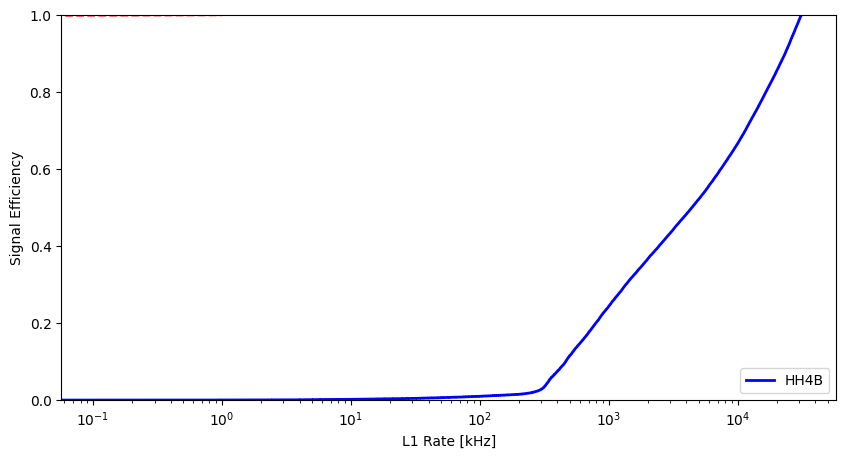

In [24]:
# Ensure model is in evaluation mode
model.eval()

# Initialize lists to store anomaly scores
background_scores = []
signal_scores = []

device = torch.device('cuda')

with torch.no_grad():
    beta = 0.5
    
    # Process background samples
    for batch in bkg_loader:  # Assume bkg_loader provides batches of data
        kin = batch['kin'].to(device)    # Shape: (batch_size, seq_len, d_kin)
        mask = batch['mask'].to(device)  # Shape: (batch_size, seq_len)
        pid = batch['pid'].to(device)

        # Get model outputs
        x_recon, kl_div, mu, log_var, z_k = model(kin, pid, mask)

        # Compute scores per event: Sum over latent_space_dim (dim=1)
        scores = torch.sum(mu ** 2, dim=1)  # Shape: (batch_size,)
        background_scores.extend(scores.cpu().numpy())  # Append per-event scores as individual entries

    # Process signal samples
    for batch in sig_loader:  # Assume sig_loader provides batches of data
        kin = batch['kin'].to(device)    # Shape: (batch_size, seq_len, d_kin)
        mask = batch['mask'].to(device)  # Shape: (batch_size, seq_len)
        pid = batch['pid'].to(device)

        # Get model outputs
        x_recon, kl_div, mu, log_var, z_k = model(kin, pid, mask)

        # Compute scores per event: Sum over latent_space_dim (dim=1)
        scores = torch.sum(mu ** 2, dim=1)  # Shape: (batch_size,)
        signal_scores.extend(scores.cpu().numpy())  # Append per-event scores as individual entries

# Convert lists of scores to numpy arrays
background_scores = np.array(background_scores)
signal_scores = np.array(signal_scores)

# Print or return scores for analysis
print("Background scores shape:", background_scores.shape)
print("Signal scores shape:", signal_scores.shape)

# Create labels
background_labels = np.zeros_like(background_scores)
signal_labels = np.ones_like(signal_scores)

# Combine scores and labels
all_scores = np.concatenate([background_scores, signal_scores])
all_labels = np.concatenate([background_labels, signal_labels])

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

fpr = fpr * (40 * 10**3) * (2760 / 3564)  # Return rate in kHz

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label="HH4B")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random classifier
plt.ylim([0.0, 1.0])
plt.xlabel('L1 Rate [kHz]')
plt.ylabel('Signal Efficiency')
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()


In [22]:
background_scores

array([0.00852564, 0.01061258, 0.00839558, ..., 0.00788978, 0.00780615,
       0.00809187], dtype=float32)

In [23]:
signal_scores

array([0.01493281, 0.00888079, 0.00792119, ..., 0.01342654, 0.01428503,
       0.00861987], dtype=float32)

/tmp/maglowac/ipykernel_3828396/2281747629.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 2e1])  # Set the range of the x-axis (zoom in)


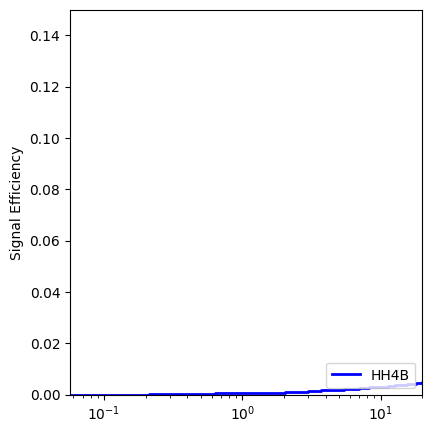

In [15]:
# Create labels
background_labels = np.zeros_like(background_scores)
signal_labels = np.ones_like(signal_scores)

# Combine scores and labels
all_scores = np.concatenate([background_scores, signal_scores])
all_labels = np.concatenate([background_labels, signal_labels])

# Compute ROC curve and AUC
# Flatten arrays
flattened_labels = all_labels.flatten()
flattened_scores = all_scores.flatten()

# Create a mask to filter out NaN values from both arrays
mask = ~np.isnan(flattened_labels) & ~np.isnan(flattened_scores)

# Apply the mask
filtered_labels = flattened_labels[mask]
filtered_scores = flattened_scores[mask]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(filtered_labels, filtered_scores)

roc_auc = auc(fpr, tpr)

fpr = fpr * (40*10**3) * (2760 / 3564) #return rate in kHz

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label="HH4B")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random classifier
plt.ylim([0.0, 0.15])  # Set y-axis limits
plt.xscale('log')  # Set x-axis to log scale
plt.xlim([0, 2e1])  # Set the range of the x-axis (zoom in)
plt.ylabel('Signal Efficiency')
plt.legend(loc='lower right')


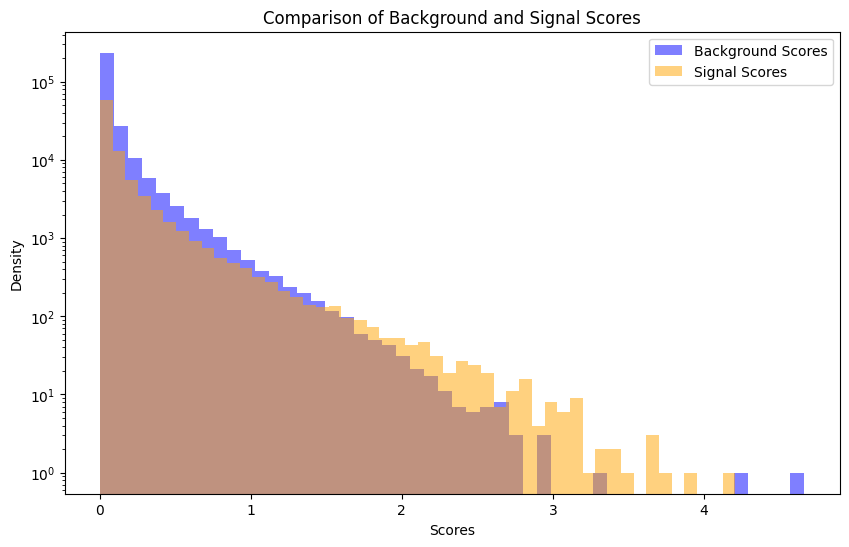

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# Plot histograms on a log scale
plt.figure(figsize=(10, 6))

# Histogram for background scores
plt.hist(background_scores, bins=50, alpha=0.5, label='Background Scores', color='blue')

# Histogram for signal scores
plt.hist(signal_scores, bins=50, alpha=0.5, label='Signal Scores', color='orange')

# Add labels, legend, and title
plt.xlabel('Scores')
plt.ylabel('Density')
plt.title('Comparison of Background and Signal Scores')

# Set the x-axis to logarithmic scale
plt.yscale('log')

plt.legend()

# Show plot
plt.show()


In [17]:
background_scores.shape

(291131,)

In [18]:
background_scores.mean()

0.08622741

: 